In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [3]:
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 211 (delta 100), reused 191 (delta 87), pack-reused 0
Receiving objects: 100% (211/211), 64.85 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (100/100), done.


---

In [4]:
import os 
from datetime import date
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import pandas as pd
import json
import pickle

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

import numpy.random as random
from src.datasets.data import SPReader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-25988acebc6a>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [6]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "SOTAEmbedding",
    "sem-space": "word-embedding",
    "model_params":{
        "linear_filters":[1024,1024,1024,300],
        "input_feat":36,
        "dropout":0.1,
    },
    "lr": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 64,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = SPReader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1092: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048],input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        # out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        # out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        # out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        # out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [10]:
model = SOTAEmbedding(
    linear_filters=config["model_params"]["linear_filters"],
    input_feat=config["model_params"]["input_feat"],
    dropout=config["model_params"]["dropout"]
)

In [11]:
emb = model(torch.randn((32,36)))
emb.size()

torch.Size([32, 300])

In [12]:
def read_word_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [13]:
# load video dataset
I3D_data_path  = data_root + '/Word_Embedding/GloVe_GNEWS_300.pickle'
with open(I3D_data_path, "rb") as pf:
    word_dict = pickle.load(pf)

# GloVe quirks
word_dict['nordic walking'] = word_dict['fitness walking']
word_dict['watching tv'] = word_dict['watching television']

In [14]:
# re-arrange semantic space 
semantic_space = np.array([word_dict[c.lower()] for c in actionList])

In [15]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

---

In [16]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [18]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [19]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

In [20]:
data_dict['train']['X'].shape,data_dict['eval-seen']['X'].shape,data_dict["test"]["X"].shape

((16752, 36), (4189, 36), (5608, 36))

In [21]:
def newLoss(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    return output

def loss_reconstruction_calc(y_pred:torch.Tensor,y_feat:torch.Tensor,loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

def predict_class(
        y_pred:torch.Tensor,
        selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [27]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [26]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
            
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            # convert feature vector into action class using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [24]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.196



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.082



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.082



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.081



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

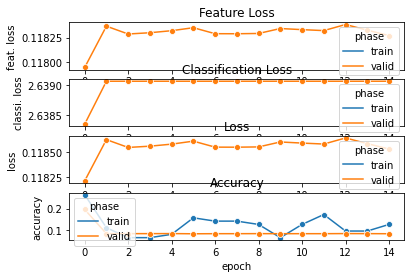

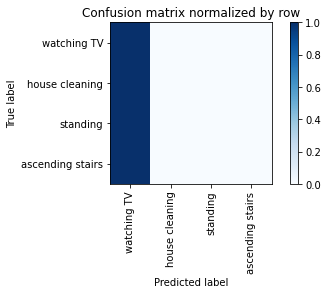

Overall accuracy: 0.148

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.000      0.000      0.000      0.331       1842|	 watching TV: 1.000,	ascending stairs: 0.000,	
  house cleaning       0.000      0.000      0.000      0.329       1830|	 watching TV: 1.000,	ascending stairs: 0.000,	standing: 0.000,	
ascending stairs       0.000      0.000      0.000      0.193       1072|	 watching TV: 1.000,	standing: 0.000,	
     watching TV       0.148      1.000      0.258      0.148        824|	 ascending stairs: 0.000,	standing: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.022      0.148      0.038        1.0       5568|	      

{'accuracy': 0.14798850574712644, 'precision': 0.03699712643678161, 'recall': 0.25, 'f1': 0.06445556946182729, 'samples': 5568, 'loss': 571.1478552818298, 'feat. loss': 570.3759469985962, 'classi. loss': 7718.

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.096



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.093



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.093



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.093



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.093



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.093



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.093



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.093



unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

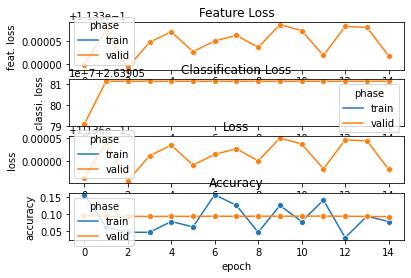

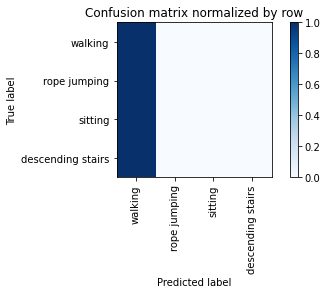

Overall accuracy: 0.421

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.421      1.000      0.593      0.421       2317|	 descending stairs: 0.000,	sitting: 0.000,	
          sitting       0.000      0.000      0.000      0.325       1790|	 walking: 1.000,	descending stairs: 0.000,	
descending stairs       0.000      0.000      0.000      0.172        944|	 walking: 1.000,	sitting: 0.000,	
     rope jumping       0.000      0.000      0.000      0.082        453|	 walking: 1.000,	descending stairs: 0.000,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.177      0.421      0.249 0.9999999999999999       5504|	      

{'accuracy': 0.42096656976744184, 'precision': 0.10524164244186046, 'recall': 0.25, 'f1': 0.14812683800025572, 'samples': 5504, 'loss': 668.520426273346, 'feat. loss': 667.757390499115, 'classi. loss': 7630.

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.048



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.097



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.096



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.096



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.096



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.095



unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

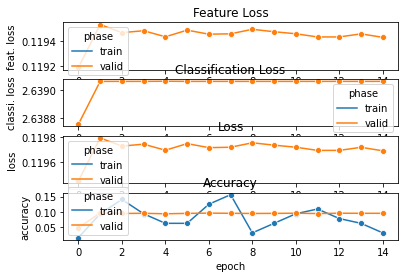

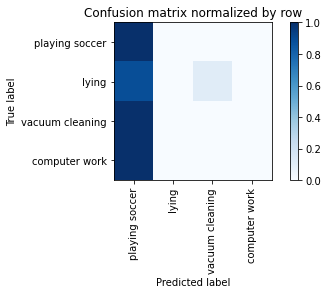

Overall accuracy: 0.064

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.000      0.000      0.000      0.432       3067|	 playing soccer: 1.000,	vacuum cleaning: 0.000,	
          lying       0.000      0.000      0.000      0.264       1875|	 playing soccer: 0.884,	vacuum cleaning: 0.116,	computer work: 0.000,	
vacuum cleaning       0.000      0.000      0.000      0.240       1705|	 playing soccer: 1.000,	computer work: 0.000,	
 playing soccer       0.066      1.000      0.124      0.064        457|	 computer work: 0.000,	vacuum cleaning: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.004      0.064      0.008        1.0       7104|	      

{'accuracy': 0.06432995495495496, 'precision': 0.016589226078118195, 'recall': 0.25, 'f1': 0.031113834422657954, 'samples': 7104, 'loss': 736.4570441246033, 'feat. loss': 735.4722471237183, 'cla

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.086



unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

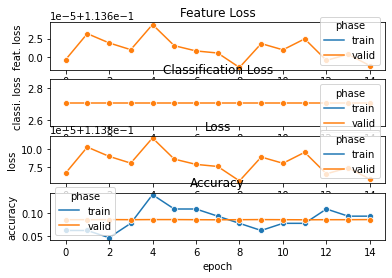

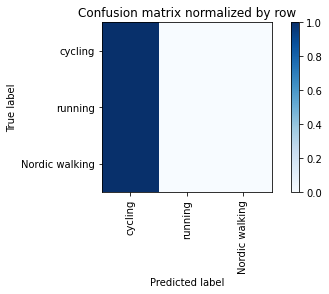

Overall accuracy: 0.366

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.000      0.000      0.000      0.419       1822|	 cycling: 1.000,	running: 0.000,	
       cycling       0.366      1.000      0.535      0.365       1590|	 Nordic walking: 0.000,	running: 0.000,	
       running       1.000      0.002      0.004      0.216        940|	 cycling: 0.998,	Nordic walking: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.350      0.366      0.197        1.0       4352|	      

{'accuracy': 0.36580882352941174, 'precision': 0.45517241379310347, 'recall': 0.3340425531914894, 'f1': 0.17986660661819898, 'samples': 4352, 'loss': 534.2438011169434, 'feat. loss': 533.7656903266907, 'classi. loss': 4781.157791137695}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.090



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.057



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.150



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.150



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.151



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.151



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.150



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.150



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.151



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.149



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.150



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.150



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.150



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.151



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.151



unseen:   0%|          | 0/60 [00:00<?, ?batch/s]

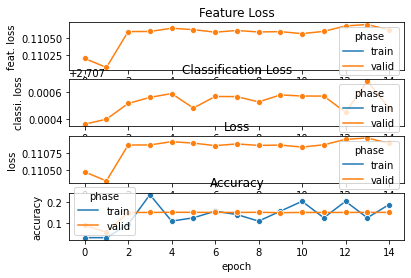

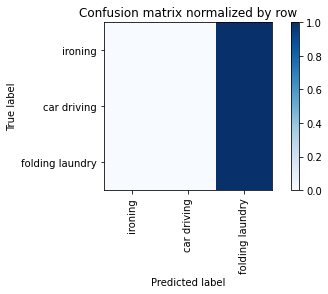

Overall accuracy: 0.253

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.608       2333|	 folding laundry: 1.000,	car driving: 0.000,	
folding laundry       0.253      1.000      0.404      0.253        971|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.140        536|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.064      0.253      0.102        1.0       3840|	      

{'accuracy': 0.25286458333333334, 'precision': 0.08428819444444445, 'recall': 0.3333333333333333, 'f1': 0.1345527610337421, 'samples': 3840, 'loss': 525.0540771484375, 'feat. loss': 524.6321611404419, 'classi. loss': 4219.182769775391}
============== Overall Unseen Classes Performance ==============


accuracy           0.250392
precision          0.139658
recall             0.283475
f1                 0.111623
samples         5273.600000
loss             607.084641
feat. loss       606.400687
classi. loss    6839.463293
dtype: float64

In [28]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=semantic_space, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'],weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', print_report=False, loss_alpha=0.0001)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)
    
    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],   phase='unseen', loss_alpha=0.0001, show_plot=True, print_report=True)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
